<a href="https://colab.research.google.com/github/zlashcomet/Comp3111LEx/blob/main/project_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Environment Setup:
This notebook is intended to be run on Google Colab.

In [ ]:
from google.colab import drive
import os
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# MODIFY YOUR PATH
data_path = "/content/drive/MyDrive/COMP4211/project/shared-files"
flickr8k_zip = os.path.join(data_path, 'flickr8k.zip')
flickr8k_path = "flickr8k"

In [ ]:
# Rather than access it directly from Google Drive, unzip the training image datasets to the Google Colab VM.
!mkdir -p "$flickr8k_path"
!unzip "$flickr8k_zip" -d "$flickr8k_path" > /dev/null 2>&1

In [ ]:
# Set it to True when you want to show the testing outputs.
Analysis_testing = True

# Imports

In [99]:
import numpy as np
import pickle
import tensorflow as tf
import re

from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, Dropout, Embedding, LSTM, Reshape, Concatenate, LayerNormalization, BatchNormalization, Add

from sklearn.model_selection import train_test_split

# Visualize running progress
from tqdm.notebook import tqdm
from tqdm.keras import TqdmCallback

# Utility
import psutil

import matplotlib.pyplot as plt

# 1. Dataset Preparation

## Feature Extraction

In [100]:
TARGET_SIZE = (224, 224)

In [101]:
# Functions for showing images
def test_display_image(img_names: str, size: None | tuple) -> None:
    """Display an image

    Args:
        img_names (list[str]): The the name of images.
        size (None | tuple): The size of image to show
    """
    img_dir_path = os.path.join(flickr8k_path, 'Images')
    img_path = os.path.join(img_dir_path, img_names)
    image: np.ndarray = img_to_array(load_img(img_path, target_size=size))
    image = image.astype(int)
    plt.figure(figsize=(5, 5))
    plt.imshow(image)
    plt.axis('off')
    plt.tight_layout()  # Make the subplots more packed
    plt.show()

def test_compare_cropped_image(img_names: list[str]) -> None:
    """It either compares the original images and resized images that fit to the VGG19

    Args:
        img_names (list[str]): The list contains names of images.
    """
    img_dir_path = os.path.join(flickr8k_path, 'Images')
    n = len(img_names)
    Sizes = [None, TARGET_SIZE]
    # Show all three img in subplot
    fig, axs = plt.subplots(2, n, figsize=(8, 8))
    for idx, size in enumerate(Sizes):
        for j in range(n):
            if idx == 0:
                Title = "Original image"
            else:
                Title = "Resized images"
            img_path = os.path.join(img_dir_path, img_names[j])
            image: np.ndarray = img_to_array(load_img(img_path, target_size=size))
            image = image.astype(int)
            axs[idx, j].imshow(image)
            axs[idx, j].set_title(Title)
            axs[idx, j].axis('off')  # Remove the axes
    fig.suptitle("Comparison of original image with resized one that fit to the VGG19")
    fig.tight_layout()  # Make the subplots more packed
    plt.show()

Obviously, the image data for captioning tasks need to be resized into `(224, 224)`, will there be better way to do the resize, then simply scaling it?

For example:
* `Cropping` into `(224, 224)` directly.
* `Cropping` and then `padding` with some monotone colour.
* `Scale` up/down the image untill one axis meet `224` pixels then do `padding`.

Also, what about image augmentation?

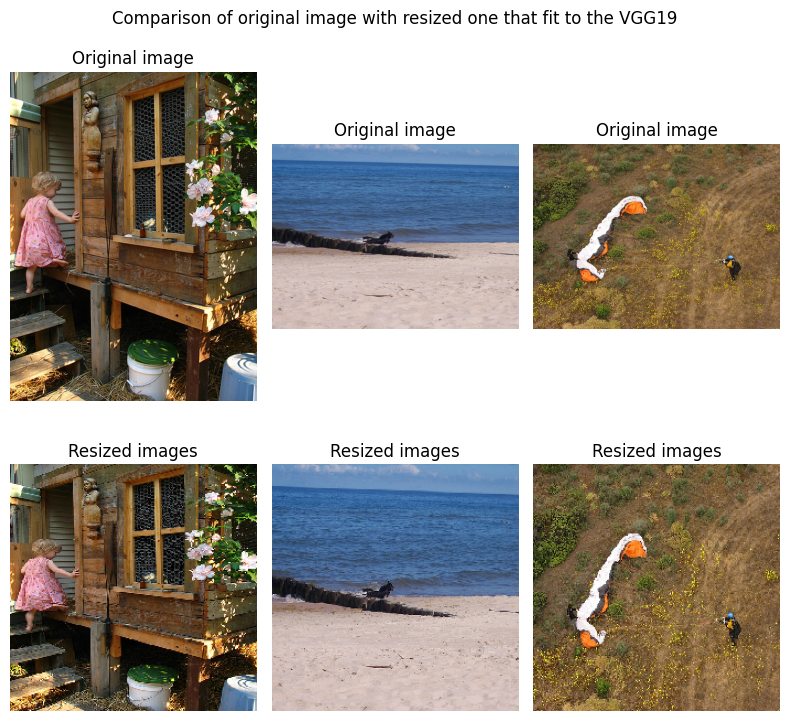

In [102]:
if Analysis_testing == True:
    # Pick three image to display
    imgs_to_display = ["1000268201_693b08cb0e.jpg", "1115679311_245eff2f4b.jpg", "2057306459_2f52ce648e.jpg"]
    test_compare_cropped_image(imgs_to_display)

In [103]:
# Load image extraction model
def load_extraction_model():
    # Load VGG19 model
    model = VGG19()
    # Modify the model and drop the final output layer (softmax) of the VGG19 model
    model = Model(inputs=model.input, outputs=model.layers[-2].output)
    return model

# Extract image features
def extract_features(dir_path: str, model):
    features = {}
    img_dir_path = os.path.join(dir_path, 'Images')
    img_names = tqdm(os.listdir(img_dir_path))
    for img_name in img_names:
        # Get the image path
        img_path = img_dir_path + '/' + img_name
        # Load and convert the image to a numpy array
        image = img_to_array(load_img(img_path, target_size=TARGET_SIZE))
        # Reshape the image to fit into the model
        image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
        # Preprocess the image
        image = preprocess_input(image)
        # Feature extraction
        feature = model.predict(image, verbose=0)
        # Store the feature
        features[img_name] = feature
    return features

# Extract image features and save it into a pickle (.pkl) file
def extract_save_features(dir_path: str, feature_path: str, model):
    features = extract_features(dir_path, model)
    f = open(feature_path, 'wb') # 'wb': Write binary
    pickle.dump(features, f)
    f.close()

# Load image features from pickle file
def load_features(feature_path: str):
    f = open(feature_path, 'rb') # 'rb': Read binary
    features = pickle.load(f)
    f.close()
    return features

In [104]:
# Load image extraction model
extraction_model = load_extraction_model()

In [105]:
extraction_model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [106]:
# Store the path of features.pkl
feature_path = os.path.join(data_path, 'features.pkl')

In [107]:
# Do NOT need to run this if the .pkl file already exists
if not os.path.exists(feature_path):
    print("Start extracting")
    extract_save_features(dir_path=flickr8k_path, feature_path=feature_path, model=extraction_model)
    print("Finish extracting")
else:
    print("The file already exist, please continue with next tasks")

The file already exist, please continue with next tasks


In [108]:
# Run this if the .pkl file already exists
if not os.path.exists(feature_path):
    raise Exception("Feature path does not exist")
features = load_features(feature_path=feature_path)
print("Features are loaded successfully")

Features are loaded successfully


In [109]:
if Analysis_testing == True:
    print(len(features))   # Should be 8091

8091


## Load Captions

In [110]:
def load_dataset(dir_path: str) -> dict:
    """
    key: image_filename
    value: [caption_1, caption_2, caption_3, caption_4, caption_5]
    """
    ds = {}
    caption_path = os.path.join(dir_path, 'captions.txt')

    # Open the caption.txt file and extract the text
    f = open(caption_path, 'r')
    next(f) # Skip the first line (i.e., "image,caption")
    doc = f.read()
    f.close()
    lines = doc.split('\n')[:-1] # Skip the last empty line

    for line in lines:
        """
        Format for each line:
        <image_filname>,<caption>
        """
        tokens = line.split(',')
        if len(tokens) < 2:
            continue
        image_filename, caption = tokens[0], tokens[1:]
        caption = ' '.join(caption)
        # Add the image filename as key if it is not in the dictionary
        if image_filename not in ds:
            ds[image_filename] = []
        # Append the caption to the caption list
        ds[image_filename].append(caption)

    return ds

In [111]:
ds = load_dataset(flickr8k_path)

In [112]:
# Check the caption
if Analysis_testing == True:
    print(len(ds))  # 8091
    for caption in ds['1079274291_9aaf896cc1.jpg']:
        print(caption)  # A little boy sticks his tongue out for the camera . Another boy looks on .
                        # Two boys make faces .
                        # "Two young boys are looking at the camera   one smiling   the other sticking his tongue out ."
                        # Two young boys look up at the camera as one sticks out his tongue .
                        # two young boys making silly faces .

8091
A little boy sticks his tongue out for the camera . Another boy looks on .
Two boys make faces .
"Two young boys are looking at the camera   one smiling   the other sticking his tongue out ."
Two young boys look up at the camera as one sticks out his tongue .
two young boys making silly faces .


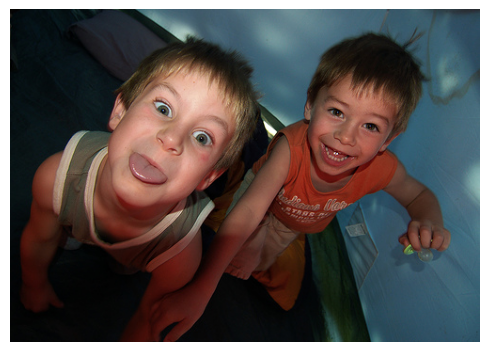

In [113]:
# Check the image
if Analysis_testing == True:
    test_display_image('1079274291_9aaf896cc1.jpg', size = None)

# 2. Data Preprocessing

## Caption Formatting

In [114]:
# Special Tokens
START = "<START>"
END = "<END>"
PAD = "<PAD>"
UNKNOWN = "<UNKNOWN>"
special_tokens = [START, END, PAD, UNKNOWN]

In [115]:
def preprocess_ds(ds: dict):
    for filename, captions in ds.items():
        for i in range(len(captions)):
            caption = captions[i]
            caption = caption.lower() # Make the caption lowercase
            caption = re.sub('[^A-Za-z\s+]', '', caption) # Delete non-alphabets
            caption = re.sub('\s+', ' ', caption) # Trim down space
            # Caption format: "<START> {token_1} {token_2} ... {token_n} <END>"
            # Remove hanging 's' and 'a'
            captions[i] = START + ' ' + ' '.join([word for word in caption.split() if len(word) > 1]) + ' ' + END
    return ds

In [116]:
# At this point, the captions stored in ds should follow the format defined above
ds = preprocess_ds(ds)

In [117]:
if Analysis_testing == True:
    for caption in ds['1079274291_9aaf896cc1.jpg']:
        print(caption)  # <START> little boy sticks his tongue out for the camera another boy looks on <END>
                        # <START> two boys make faces <END>
                        # <START> two young boys are looking at the camera one smiling the other sticking his tongue out <END>
                        # <START> two young boys look up at the camera as one sticks out his tongue <END>
                        # <START> two young boys making silly faces <END>

<START> little boy sticks his tongue out for the camera another boy looks on <END>
<START> two boys make faces <END>
<START> two young boys are looking at the camera one smiling the other sticking his tongue out <END>
<START> two young boys look up at the camera as one sticks out his tongue <END>
<START> two young boys making silly faces <END>


In [118]:
def get_vocab_variables(ds: dict):
    word_to_index = {}
    index_to_word = {}
    word_freq = {}
    max_length = 0

    # For every caption, extract every word and count the frequencies of the tokens
    for filename, captions in ds.items():
        for caption in captions:
            tokens = caption.split(' ')
            max_length = max(max_length, len(tokens))
            for token in tokens:
                if token not in word_freq.keys():
                    word_freq[token] = 0
                word_freq[token] += 1

    # Filter out words that occur less than 5 times and special tokens
    trimmed_word_freq = sorted({word : freq for word, freq in word_freq.items() if freq >= 5 and word not in special_tokens})

    # i: Number of words that are not special tokens
    i = len(trimmed_word_freq)

    # Note: The mapping starts from 1 as 0 is reserved for the pad token <PAD>
    for index, word in enumerate(trimmed_word_freq, start=1):
        word_to_index[word] = index
        index_to_word[index] = word

    # Pad token index: 0 (Zero padding)
    word_to_index[PAD] = 0
    index_to_word[0] = PAD

    # Start token index: i + 1
    word_to_index[START] = i + 1
    index_to_word[i + 1] = START

    # End token index: i + 2
    word_to_index[END] = i + 2
    index_to_word[i + 2] = END

    # Unknown word token: i + 3
    word_to_index[UNKNOWN] = i + 3
    index_to_word[i + 3] = UNKNOWN

    return word_to_index, index_to_word, len(word_to_index), max_length

In [119]:
word_to_index, index_to_word, num_vocab, max_length = get_vocab_variables(ds)

In [120]:
if Analysis_testing == True:
    print(word_to_index[PAD])       # 0
    print(word_to_index[START])     # 2982
    print(word_to_index[END])       # 2983
    print(word_to_index[UNKNOWN])   # 2984
    print(len(word_to_index))       # 2985
    print(len(index_to_word))       # 2985
    print(num_vocab)                # 2985
    print(max_length)               # 34

0
2982
2983
2984
2985
2985
2985
34


In [121]:
if Analysis_testing == True:
    print(ds['1000268201_693b08cb0e.jpg'])  # ['<START> child in pink dress is climbing up set of stairs in an entry way <END>',
                                            #  '<START> girl going into wooden building <END>',
                                            #  '<START> little girl climbing into wooden playhouse <END>',
                                            #  '<START> little girl climbing the stairs to her playhouse <END>',
                                            #  '<START> little girl in pink dress going into wooden cabin <END>']

['<START> child in pink dress is climbing up set of stairs in an entry way <END>', '<START> girl going into wooden building <END>', '<START> little girl climbing into wooden playhouse <END>', '<START> little girl climbing the stairs to her playhouse <END>', '<START> little girl in pink dress going into wooden cabin <END>']


## Word Embedding

In [122]:
def load_embeddings():
    embeddings = {}
    glove_path = os.path.join(data_path, 'glove.6B.50d.txt')
    f = open(glove_path, encoding='utf8')
    for line in f:
        values = line.split()
        word = values[0]
        embeddings[word] = np.array(values[1:], dtype='float')
    f.close()
    return embeddings

def get_embedding_matrix(num_vocab: int, word_to_index: dict, embeddings: dict):
    emb_dim = 50
    embedding_matrix = np.zeros((num_vocab, emb_dim))
    for word, index in word_to_index.items():
        embedding_vector = embeddings.get(word)
        if embedding_vector is not None:
            embedding_matrix[index] = embedding_vector
    return embedding_matrix

In [123]:
embeddings = load_embeddings()
embedding_matrix = get_embedding_matrix(num_vocab, word_to_index, embeddings)

In [124]:
embedding_matrix.shape  # (2985, 50)

(2985, 50)

## Caption Data Batch Generation

In [125]:
# A generator: A special kind of function that can pause and resume their execution without reseting the state (e.g., iteration)
def batch_data_generator(ds: dict, features: dict, word_to_index: dict, max_length: int, num_vocab: int, batch_size: int):
    """It generates a batch of data for training the model

    Args:
        ds (dict): The image caption dataset
        features (dict): A dictionary containing the image's feature vectors
        word_to_index (dict): A dictionary mapping words to their corresponding index
        max_length (int): The maximum length of the caption
        num_vocab (int): The number of vocabulary
        batch_size (int): The number of samples to be generated in a batch

    Yields:
        Anon_object (list): A list containing the image's feature vectors, partial captions, and target words
    """

    img_features, partial_captions, target_words = [], [], []
    """
    img_features (list): A list of feature vectors
    partial_captions (list): A list of tokenized and indexed captions in the format below:
    [
            ['<START>' '<PAD>' '<PAD>' ... '<PAD>' '<PAD>' '<PAD>' ... '<PAD>'],
            ['<START>' '<WORD_1>' '<PAD>' ... '<PAD>' '<PAD>' '<PAD>' ... '<PAD>'],
            ['<START>' '<WORD_1>' '<WORD_2>' ... '<PAD>' '<PAD>' '<PAD>' ... '<PAD>'],
            ...
            ['<START>' '<WORD_1>' '<WORD_2>' ... '<WORD_N-1>' '<PAD>' '<PAD>' ... '<PAD>'],
    ]
    target_words (list): A list of the indexed proceeding word of the caption, presented in one-hot encoded form
    """

    n = 0
    while True:
        for filename, captions in ds.items():
            n += 1
            feature = features[filename]
            for caption in captions:
                sequence = [word for word in caption.split()]

                # Convert the words into their correspoinding word index
                for j in range(len(sequence)):
                    if sequence[j] in word_to_index:
                        sequence[j] = word_to_index[sequence[j]]
                    else: # If the word does not exist in the dictionary, assign the index of '<UNKNOWN>' to it
                        sequence[j] = word_to_index[UNKNOWN]

                for i in range(1, len(sequence)):
                    xi = sequence[0:i]
                    yi = sequence[i]

                    # Pad the list with the corresponding index of '<PAD>' at the back of the sequence until the length reaches the maximum length of the caption
                    xi = pad_sequences([xi], maxlen=max_length, value=word_to_index[PAD], padding='post')[0]
                    yi = to_categorical([yi], num_classes=num_vocab)[0]

                    img_features.append(feature)
                    partial_captions.append(xi)
                    target_words.append(yi)

                # When the number of samples reaches the batch size, it returns the list of data required immediately
                # However, the state of the function is kept, meaning that the iteration from previous calls will not be reseted
                if n == batch_size:
                    yield np.array(img_features), np.array(partial_captions), np.array(target_words)
                    img_features, partial_captions, target_words = [], [], [] # The next call will start from here, continuing the iteration from the last call
                    n = 0 # Reset the number of samples obtained

In [126]:
if Analysis_testing == True:
    test_generator = batch_data_generator(ds, features, word_to_index, max_length, num_vocab, 1)

In [127]:
# Please do NOT run more than once for debug purpose
if Analysis_testing == True:
    test_batch = next(test_generator) # Each call of next() will do an iteration using the generator

In [128]:
if Analysis_testing == True:
    print(test_batch[0].shape) # (15, 1, 4096)
    print(test_batch[0]) # [[0. 1.8023192 0. ... 0. 0. 0.]] * 15

(15, 1, 4096)
[[[0.        1.8023192 0.        ... 0.        0.        0.       ]]

 [[0.        1.8023192 0.        ... 0.        0.        0.       ]]

 [[0.        1.8023192 0.        ... 0.        0.        0.       ]]

 ...

 [[0.        1.8023192 0.        ... 0.        0.        0.       ]]

 [[0.        1.8023192 0.        ... 0.        0.        0.       ]]

 [[0.        1.8023192 0.        ... 0.        0.        0.       ]]]


In [129]:
if Analysis_testing == True:
    print(test_batch[1].shape) # (15, 34)
    print(test_batch[1])    # [[2982 0*33]
                            #  [2982  490 0*32]
                            #  [2982  490 1271 0*31]
                            #  [2982  490 1271 1868 0*30]
                            #  [2982  490 1271 1868  762 0*29]
                            #  [2982  490 1271 1868  762 1304 0*28]
                            #  [2982  490 1271 1868  762 1304  524 0*287]
                            #  [2982  490 1271 1868  762 1304  524 2813 0*26]
                            #  [2982  490 1271 1868  762 1304  524 2813 2212 0*25]
                            #  [2982  490 1271 1868  762 1304  524 2813 2212 1688 0*24]
                            #  [2982  490 1271 1868  762 1304  524 2813 2212 1688 2460 0*23]
                            #  [2982  490 1271 1868  762 1304  524 2813 2212 1688 2460 1271 0*22]
                            #  [2982  490 1271 1868  762 1304  524 2813 2212 1688 2460 1271   48 0*21]
                            #  [2982  490 1271 1868  762 1304  524 2813 2212 1688 2460 1271   48 2984 0*20]
                            #  [2982  490 1271 1868  762 1304  524 2813 2212 1688 2460 1271   48 2984 2894 0*19]]
    for i in range(test_batch[1].shape[0]):
        print(list(map(lambda x: index_to_word[x], test_batch[1][i]))[i])    # <START>
                                                                                # child
                                                                                # in
                                                                                # pink
                                                                                # dress
                                                                                # is
                                                                                # climbing
                                                                                # up
                                                                                # set
                                                                                # of
                                                                                # stairs
                                                                                # in
                                                                                # an
                                                                                # <UNKNOWN>
                                                                                # way

(15, 34)
[[2982    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0]
 [2982  490    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0]
 [2982  490 1271    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0]
 [2982  490 1271 1868    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0]
 [2982  490 1271 1868  762    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0]
 [2982  490 1271 1868  762 1304    0    0    0    0    0    0    0    0
     0    0    0    0    0    0   

In [130]:
if Analysis_testing == True:
    print(test_batch[2].shape) # (15, 2985)
    print(np.argmax(test_batch[2], axis=1)) # [490 1271 1868 762 1304 524 2813 2212 1688 2460 1271 48 2984 2894 2983]

(15, 2985)
[ 490 1271 1868  762 1304  524 2813 2212 1688 2460 1271   48 2984 2894
 2983]


# Model Training

Important terms:

1. `features`: This is a dictionary where each key is the filename of an image (e.g., `1000268201_693b08cb0e.jpg`), and the corresponding value is a feature vector of length `4096` extracted from the image using the `VGG19` model.

2. `ds`: This is another dictionary where each key is an image filename, and the corresponding value is a list of captions for that image, it has size of `8091`. Each caption is a sentence that describes the image and is enclosed within `<START>` and `<END>` tokens. Note: `ds` is preprocessed already at this point.

3. `embedding_matrix`: This is a 2D numpy array where each row corresponds to a word in the vocabulary. The row contains a `50`-dimensional vector representation of the word. The total number of rows is `2985`, which is the size of the vocabulary.

4. `batch_data_generator`: This is a generator that produces batches of data for training a machine learning model. Each iteration yields a batch of data in a specific format `[[np.array(img_features),np.array(partial_captions)], np.array(target_words)]`:
    - `img_features`: This array contains feature vectors for each image in the batch, extracted using the VGG19 model.
    - `partial_captions`: This array contains tokenized partial captions. Each caption starts with a `<START>` token and is filled with `<PAD>` tokens until it reaches the maximum sentence length.
    - `target_words`: A numpy array contains the target words for the partial captions. These are the words that the model will learn to predict.

5. `word_to_index`: This is a dictionary that maps each word in the vocabulary to a unique index.

6. `index_to_word`: This is a dictionary that maps each index to the corresponding word in the vocabulary.

7. `num_vocab`: This is the total number of words in the vocabulary, which is `2985`.

8. `max_length`: This is the maximum length of any sentence in the captions, which is `34`. It is used to standardize the length of all sentences by padding shorter ones.

## Model overview
1. **Encoder (VGG19)**: The encoder is a CNN model, specifically VGG19, which is used to extract features from the input images. In this project, the VGG19 model is used as a fixed feature extractor, where the extracted features are passed into `input_VGG19_feature_vectors`. These features are then passed through a Dense layer with ReLU activation, optionally followed by Batch Normalization.

2. **Caption Embedding**: The target captions, which are the sentences describing the images, are passed into an embedding layer. This layer converts each word in the captions into a 50-dimensional vector. These vectors capture the semantic meaning of the words. The embedding layer is created with its weights initialized to the embedding matrix. If `embedding_train` is set to True, this layer is trainable, which means its weights can be updated during training. Otherwise, the weights are frozen.

3. **Decoder (LSTM)**: The decoder is a LSTM model. The LSTM is never frozen. The decoder performs the following steps:
   - The output of the Embedding layer is passed through a Dropout layer and then an LSTM layer. Here, we try to capture the temporal dependencies in the captions.
   - The processed image and caption inputs are then concatenated together. This combined input is passed through another LSTM layer and Dropout.
   - If the `high_way` flag is set to True, a highway connection is added. This involves adding the output of the second LSTM layer to the output of the first LSTM layer. Assumption: the highway connections can improve the flow of information through the network.
   - A Dense layer with a ReLU activation function is created that takes the output of the LSTM layer, followed by Dropout, and then another Dense layer with softmax activation. It compute the probability distribution over the vocabulary for the next word in the caption to predict the next word in the generated caption.

## Model building

In [131]:
def ImageCaption_Build_Model(dropout_val: float, embedding_train: bool, normalize: bool, high_way: bool, max_length: int, num_vocab: int, embedding_matrix):
    """Build the image captioning model

    Args:
        dropout_val (float): Dropout value for all dropout layers
        embedding_train (bool): Whether the weights on the embedding layer is trainable
        normalize (bool): Whether to use normalization layers (BN and LN)
        high_way (bool): Whether to use highway connections
        max_length (int): The maximum length of a caption sentence
        num_vocab (int): The number of unique words in the vocabulary list
    Returns:
        model: The image captioning model
    """

    # Image input: pre-extracted VGG19 feature vectors
    input_VGG19_feature_vectors  = Input(shape=(4096,), name="image_input")

    # Caption input: sequences of words
    input_text = Input(shape=(max_length,), name="text_input")

    # Embedding layer for the caption input
    Embedding_layer = Embedding(input_dim=num_vocab, output_dim=50,
                                weights=[embedding_matrix],
                                mask_zero = True, trainable=embedding_train)
    input_text_enc_1 = Embedding_layer(input_text)
    input_text_enc_2 = Dropout(dropout_val)(input_text_enc_1)
    input_text_enc_3 = LSTM(256)(input_text_enc_2)

    # Optional Layer Normalization
    if normalize == True:
        input_text_enc_3 = LayerNormalization()(input_text_enc_3)
    input_text_enc_3 = Reshape((1, 256))(input_text_enc_3)

    # Dense layer for the image input
    input_img_fe_1 = Dense(256, activation='relu')(input_VGG19_feature_vectors)

    # Optional Batch Normalization
    if normalize == True:
        input_img_fe_1 = BatchNormalization()(input_img_fe_1)
    input_img_fe_1 = Reshape((1, 256))(input_img_fe_1)

    # Combine the processed image and caption inputs
    combine_input = Concatenate(axis=1)([input_img_fe_1, input_text_enc_3])
    lstm_out_1 = LSTM(256)(combine_input)
    lstm_out_2 = Dropout(dropout_val)(lstm_out_1)

    # Optional highway connection
    if high_way == True:
        lstm_out_2 = Add()([lstm_out_2, input_text_enc_3])

    # Output layers
    dense_out_1 = Dense(256, activation='relu')(lstm_out_2)
    dense_out_2 = Dropout(dropout_val)(dense_out_1)
    output = Dense(num_vocab, activation='softmax')(dense_out_2)

    # Define the model
    model = Model(inputs=[input_VGG19_feature_vectors, input_text], outputs=output)

    return model

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 text_input (InputLayer)     [(None, 34)]                 0         []                            
                                                                                                  
 embedding_2 (Embedding)     (None, 34, 50)               149250    ['text_input[0][0]']          
                                                                                                  
 image_input (InputLayer)    [(None, 4096)]               0         []                            
                                                                                                  
 dropout_6 (Dropout)         (None, 34, 50)               0         ['embedding_2[0][0]']         
                                                                                            

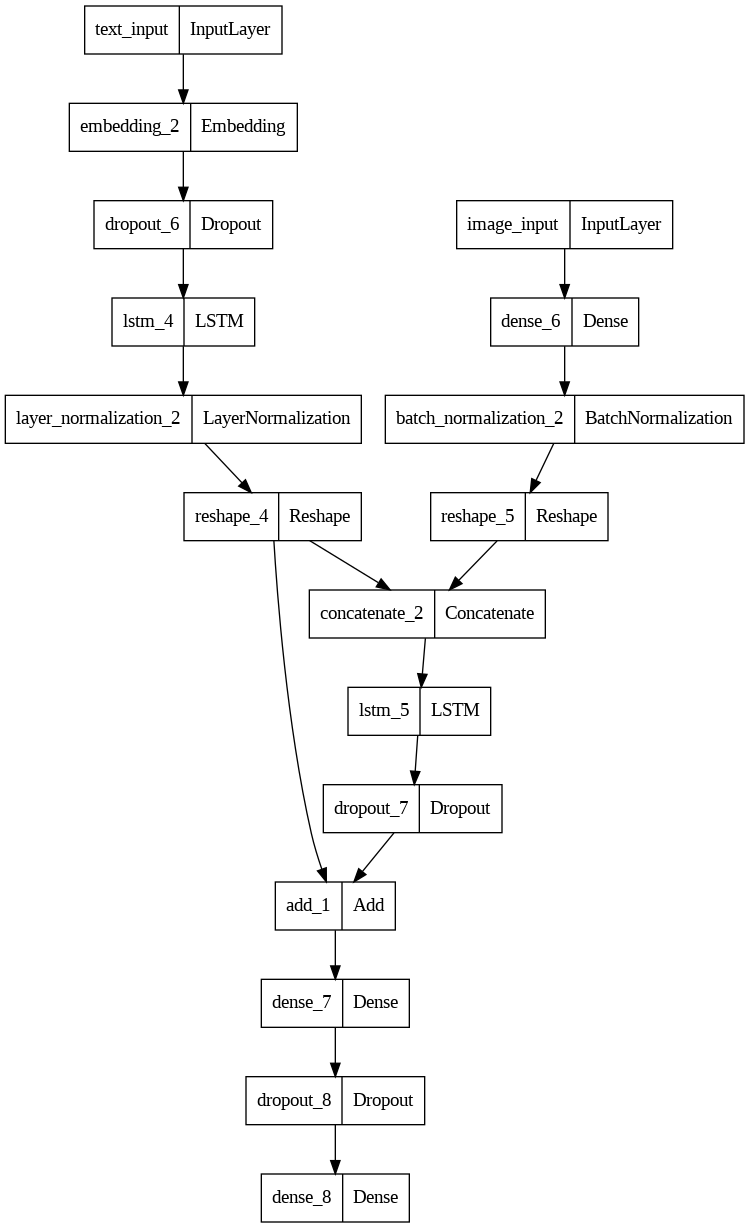

In [132]:
test_model = ImageCaption_Build_Model(dropout_val=0.5, embedding_train=True, normalize=True, high_way=True, max_length=max_length, num_vocab=num_vocab, embedding_matrix=embedding_matrix)
test_model.summary()
plot_model(test_model)

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 text_input (InputLayer)     [(None, 34)]                 0         []                            
                                                                                                  
 embedding_3 (Embedding)     (None, 34, 50)               149250    ['text_input[0][0]']          
                                                                                                  
 image_input (InputLayer)    [(None, 4096)]               0         []                            
                                                                                                  
 dropout_9 (Dropout)         (None, 34, 50)               0         ['embedding_3[0][0]']         
                                                                                            

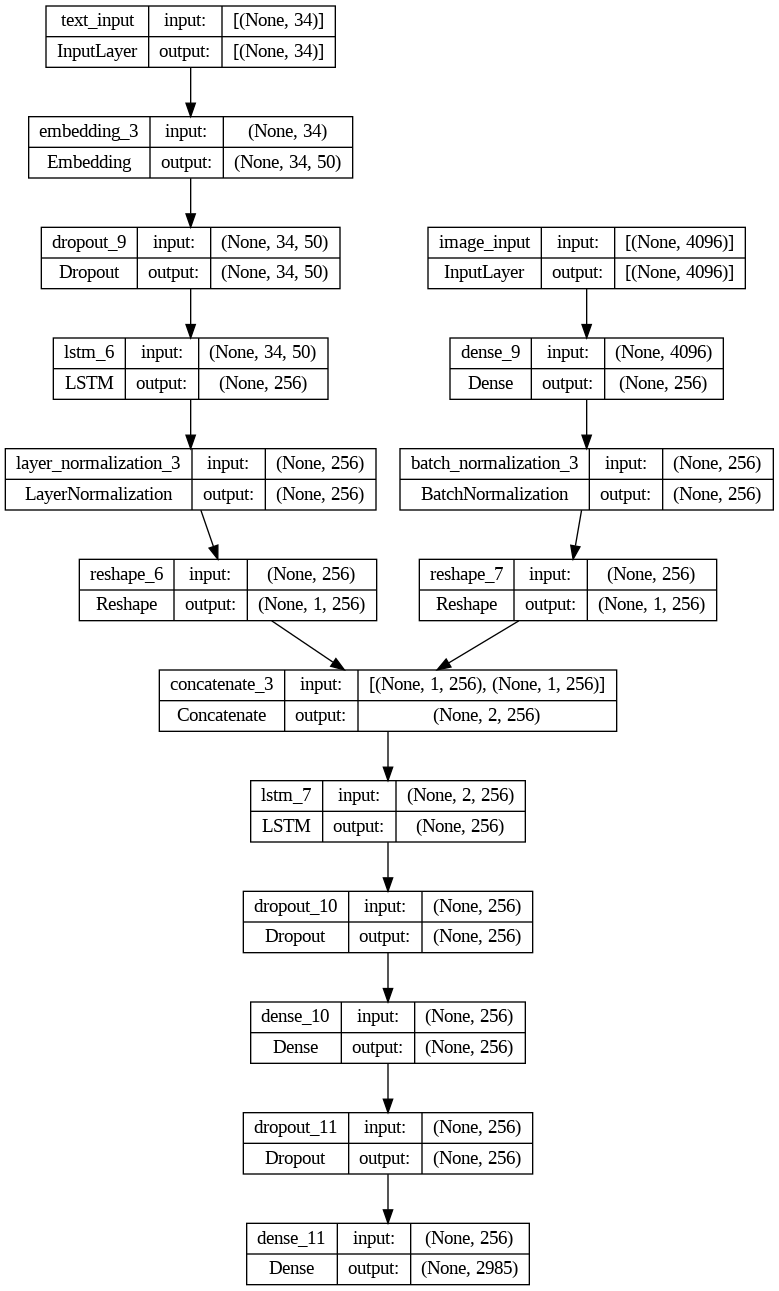

In [133]:
test_model2 = ImageCaption_Build_Model(dropout_val=0.5, embedding_train=True, normalize=True, high_way=False, max_length=max_length, num_vocab=num_vocab, embedding_matrix=embedding_matrix)
test_model2.summary()
plot_model(test_model2, show_shapes=True)

# Data Splitting


In [134]:
def prepare_Model_Data(preprocessed_dataset: dict[str, str]) -> tuple[dict[str, str], dict[str, str]]:
    """Prepare the dataset for training the model

    Args:
        preprocessed_dataset (dict[str, str]): The preprocessed dataset, ds

    Raises:
        ValueError: If the length of the dataset is not 8091

    Returns:
        train_ds, test_ds (tuple[dict[str, str], dict[str, str]]): The training and testing datasets
    """
    if len(preprocessed_dataset) != 8091:
        raise ValueError(f"Wrong length of ds, it should be 8091, get {len(preprocessed_dataset)} instead")

    # Split the keys into training and testing datasets
    keys: list[str] = list(preprocessed_dataset.keys())
    train_keys, test_keys = train_test_split(keys, test_size=0.2)  # 80% training, 20% testing

    train_ds: dict[str, str] = {key: preprocessed_dataset[key] for key in train_keys}
    test_ds: dict[str, str] = {key: preprocessed_dataset[key] for key in test_keys}

    return train_ds, test_ds

In [135]:
train_ds, test_ds = prepare_Model_Data(ds)

In [136]:
if Analysis_testing == True:
    print(len(train_ds))    # 6472
    print(len(test_ds))     # 1619

6472
1619


# Model Training

In [137]:
def train(model, ds, features, word_to_index, max_length, num_vocab, batch_size, num_epochs, save_interval, save_path, load_path):
    # Initialize the optimizer and loss funtion
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4, weight_decay=5e-5, name='Adam')
    loss_fn = tf.keras.losses.CategoricalCrossentropy()

    # Calculate the number of batches per epoch
    num_batches = len(ds) // batch_size

    # Initialize other things
    process = psutil.Process(os.getpid())

    # Load weights if provided
    if load_path:
        model.load_weights(load_path)

    for e in range(1, num_epochs + 1):
        pbar = tqdm(total=num_batches)
        generator = batch_data_generator(ds, features, word_to_index, max_length, num_vocab, batch_size)

        # Define Loss Metrics. To be updated in each batch
        losses = {"Cross-entropy": 0.0}

        for i in range(num_batches):
            batch = next(generator)

            for j in range(batch[0].shape[0]):
                with tf.GradientTape() as tape:
                    predicted_labels = model([batch[0][j], batch[1][j].reshape(1,-1)])
                    loss = loss_fn(batch[2][j].reshape(1,-1), predicted_labels)
                    gradients = tape.gradient(loss, model.trainable_weights)
                    optimizer.apply_gradients(zip(gradients, model.trainable_weights))

                # Update Loss Metrics
                losses['Cross-entropy'] = (losses['Cross-entropy'] * i + loss) / (i + 1)

                # Visualize loss during training
                epoch_string = "".join([f"{key} loss: {value:.3f}\t" for key, value in losses.items()])
                pbar.set_description(f"Epoch {e}/{num_epochs}\t" + epoch_string)

            pbar.update(1)
        # In case the session ends before the training is done, perform save the model from time to time:
        if e % save_interval == 0:
            if save_path:
                model.save(save_path)

In [138]:
# MODIFY PATH
SAVE_PATH = "model.h5"
LOAD_PATH = "model.h5"

In [ ]:
train(model=test_model2, ds=train_ds, features=features, word_to_index=word_to_index, max_length=max_length, num_vocab=num_vocab, batch_size=8, num_epochs=1, save_interval=1, save_path=SAVE_PATH, load_path=None)

In [153]:
class Inference:
    """A class for generating captions for images using the trained model
    """
    def __init__(self, model, ds, features, word_to_index, index_to_word, max_length):
        """Initialize the Inference class

        Args:
            model (Any): The trained model
            ds (dict): The dataset, either train_ds or test_ds
            features (dict): A dictionary containing the image's feature vectors
            word_to_index (dict): A dictionary mapping words to their corresponding index
            index_to_word (dict): A dictionary mapping index to their corresponding word
            max_length (int): The maximum length of a caption sentence
        """
        self.model = model
        self.ds = ds
        self.features = features
        self.word_to_index = word_to_index
        self.index_to_word = index_to_word
        self.max_length = max_length

    def Captioning_Greedy(self, img_name: str) -> str:
        """Generate a caption for an image using the greedy search algorithm

        Args:
            img_name (str): The name of the image

        Returns:
            output_Text_detokenized: The caption generated by the model
        """
        # Image info
        img_FeVector: np.ndarray = features[img_name]   # (1, 4096)

        # Text info, start as the <'START'> token
        output_Text: list[int] = [word_to_index[START]]

        for i in range(1, max_length):  # 34
            input_text = output_Text[0:i]
            input_text = pad_sequences([input_text], maxlen=max_length, value=word_to_index[PAD], padding='post')[0]
            input_text = np.array(input_text).reshape(1, -1)

            prediction = self.model.predict([img_FeVector.reshape(1, -1), input_text], verbose=0)
            best_word_idx = int(np.argmax(prediction))

            # Adding the predicted word to the next input
            output_Text.append(best_word_idx)

            # Stop predict next word when the model returns the <'END'> token
            if best_word_idx == word_to_index[END]:
                break

        # Filter out <'START'> and <'END'> tokens
        output_Text_f1: list[int] = list(filter(lambda x: x not in [word_to_index[START], word_to_index[END]], output_Text))

        # Convert the indices back into words
        output_Text_f2: list[str] = list(map(lambda x: index_to_word[x], output_Text_f1))

        # Convert the list of words into a single string
        output_Text_detokenized = ' '.join(output_Text_f2)
        return output_Text_detokenized

    def Captioning_BeamSearch(self, img_name: str) -> str:
        """Generate a caption for an image using the beam search algorithm
        """
        raise NotImplementedError("Beam Search is not implemented yet")

In [154]:
test_infer = Inference(test_model2, train_ds, features, word_to_index, index_to_word, max_length)

In [155]:
def test_Non_train_model_inference(numImg: int):
    Img_num = 0
    for name in train_ds.keys():
        if Img_num> numImg:
            break
        test_display_image(name, None)
        print(test_infer.Captioning_Greedy(name))
        Img_num += 1

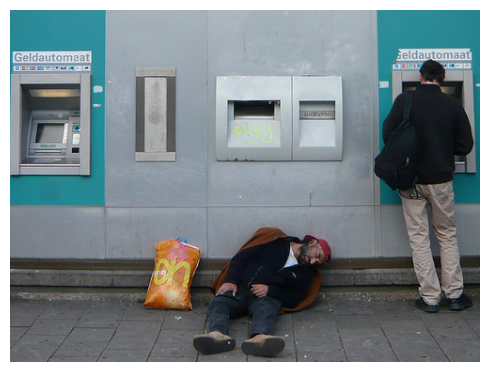

worn event diner chickens jagged harnesses basket ball ball ball ball scuba shirted shirted shirted shirted sheep cats cats powder powder harnesses harnesses harnesses harnesses event event robe shawl event shawl shawl collars


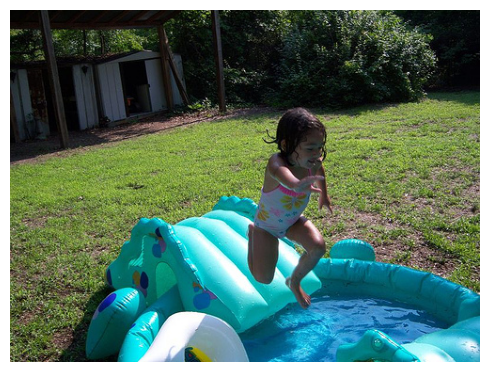

scary kangaroo compete nice compete coats pirates pirates parent parent parent parent nice gliding compete pirates strollers pirates pirates style style gliding climbers shirted shirted shirted pitches shirted pitches windows signal balloon sheep


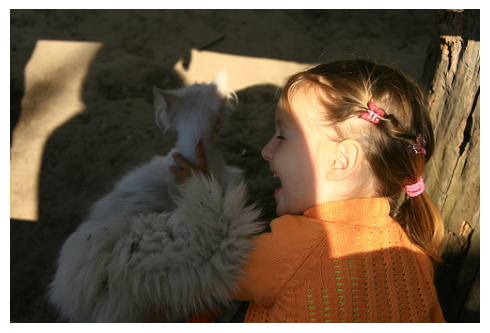

collars collars collars collars collars collars collars collars collars collars collars collars collars collars collars collars collars collars collars collars collars collars collars collars collars collars collars collars collars collars collars collars collars


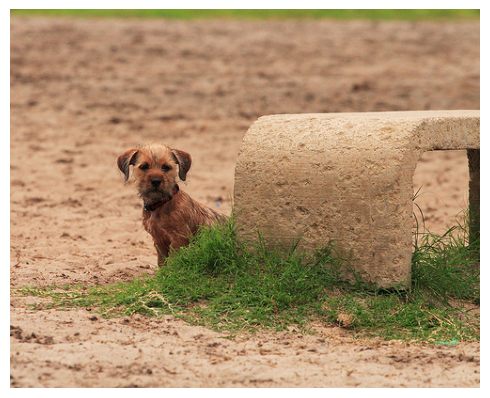

left shade sleeveless ramps puck ball shade sleeveless shade event flag flag ramps arena arena shade booth shade booth flag flag ramps pushes paintball puck ramps ball ball crocodile croquet croquet croquet croquet


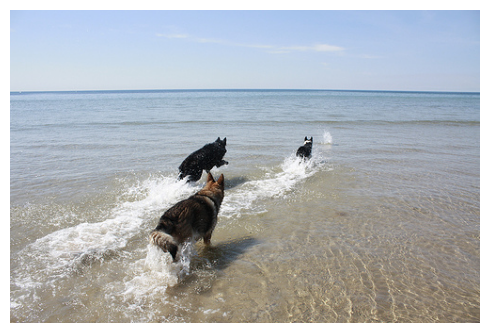

pretend dune wide standing crocodile shirted shirted pitches shirted slide crowd balloon balloon wide flag shirted shirted shirted slide shirted slide wide balloon wide balloon wide flag shirted shirted shirted slide shirted slide


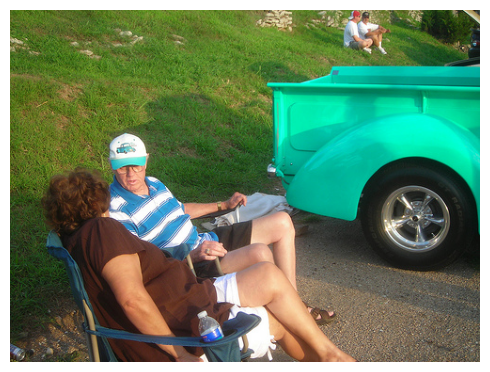

waving pitches carry carry nice wakeboards wakeboards wakeboards wakeboards wakeboards wakeboards wakeboards wakeboards wind babies snowcovered snowcovered snowcovered snowcovered snowcovered snowcovered snowcovered snowcovered snowcovered snowcovered snowcovered snowcovered snowcovered snowcovered snowcovered snowcovered snowcovered snowcovered


In [156]:
test_Non_train_model_inference(5)